In [1]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
#import mne

# graphical libs
from matplotlib import pyplot as plt
%matplotlib widget

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ml libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, classification_report, mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter, filtfilt, butter

import optuna
from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output

# Model serialization
import pickle

import serial
import time

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import add_diff, get_mse, preprocessing_0, preprocessing_1, reset_random_seeds, callbacks
from utils.figures import get_signals_plot, get_signals_comparison_plot, plot_history #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements_2', 'gestures_test_2', 'gestures_train_2', 'gestures_protocol_2', 'gestures_protocol', 'gestures_test', 'gestures_train', 'free_movements'])

### Gestures train and test

In [6]:
gestures_train = mounts['gestures_train']

print(gestures_train.shape)
gestures_train.head()

(28976, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,10,8,29,2846,2929,2873,2598,24,8,6,...,32,37,50,54,44,5,0,0,0,1174956
1,10,8,28,2846,2931,2873,2597,24,8,13,...,31,37,50,54,44,5,0,0,0,1174989
2,16,8,29,2847,2930,2875,2598,24,8,6,...,31,37,50,54,44,5,0,0,0,1175022
3,10,8,29,2847,2930,2875,2598,25,8,5,...,30,37,50,54,44,5,0,0,0,1175055
4,0,8,29,2845,2927,2870,2594,24,8,6,...,30,37,50,54,44,5,0,0,0,1175088


In [7]:
gestures_test = mounts['gestures_test']

print(gestures_test.shape)
gestures_test.head()

(7244, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
28976,10,9,38,2994,3119,2996,2773,38,9,6,...,19,25,28,32,17,6,0,0,0,2131164
28977,10,8,35,2989,3117,2996,2766,36,8,6,...,26,25,28,32,17,6,0,0,0,2131197
28978,10,8,32,2983,3113,2993,2763,36,8,5,...,29,25,28,32,17,6,0,0,0,2131230
28979,10,9,37,2986,3113,2992,2763,37,9,6,...,30,25,28,32,17,6,0,0,0,2131263
28980,10,8,36,2987,3115,2993,2762,35,8,6,...,28,25,28,32,17,6,0,0,0,2131296


In [8]:
# Обозначение колонок для удобства доступа
OMG_CH = [str(i) for i in range(50)]

ACC_CH = config.ACC_CH
GYR_CH = config.GYR_CH
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем
#GLOVE_CH = GLOVE_CH
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

col_diff_names = [x + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

col_diff_names = [x + '_DIFF' for x in OMG_CH]

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### Protocol

In [9]:
gestures_protocol = mounts['gestures_protocol']
gestures_protocol.head(11)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [10]:
gestures_train[ACC_CH].describe()

,ACC0,ACC1,ACC2
count,28976.000000,28976.000000,28976.000000
mean,-28.495099,-33.659028,94.117753
std,28.134004,38.160497,62.468246
min,-124.000000,-150.000000,-8.000000
25%,-49.000000,-41.000000,23.000000
50%,-32.000000,-35.000000,87.000000
75%,0.000000,-28.000000,158.000000
max,58.000000,105.000000,209.000000


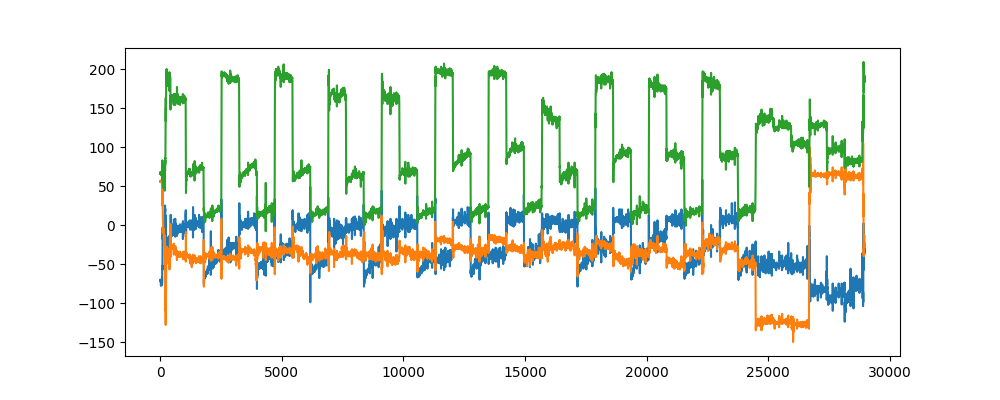

In [11]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 4)) # plt.sca(axes)
plt.plot(gestures_train[ACC_CH])
plt.show()

In [12]:
gestures_train[GYR_CH].describe()

,GYR0,GYR1,GYR2
count,28976.000000,28976.000000,28976.000000
mean,20.318229,-37.564364,32.187845
std,18.926741,52.316375,19.352442
min,-304.000000,-789.000000,-348.000000
25%,16.000000,-41.000000,28.000000
50%,20.000000,-37.000000,32.000000
75%,24.000000,-34.000000,36.000000
max,282.000000,867.000000,292.000000


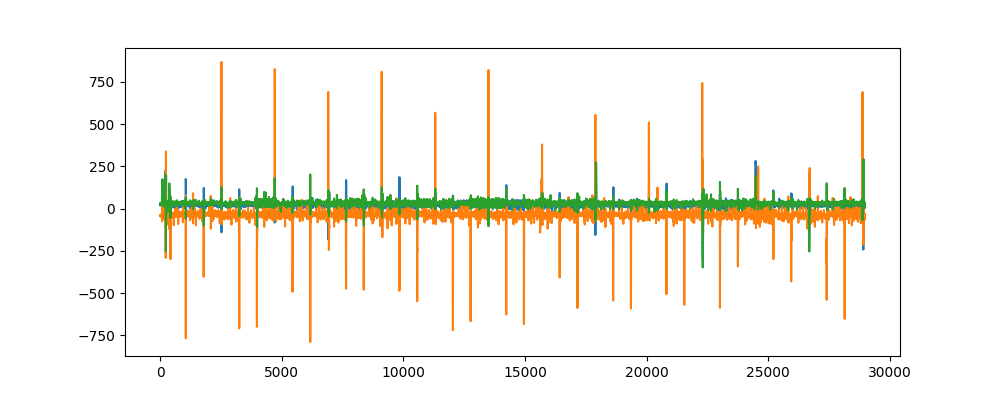

In [13]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 4)) # plt.sca(axes)
plt.plot(gestures_train[GYR_CH])
plt.show()

In [14]:
gestures_protocol[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2

array([[ 0., -2., -4., -6., -8.],
       [ 0., -2., -4., -6., -8.],
       [ 1., -2., -4., -6., -8.],
       ...,
       [ 0., -2., -4., -6., -8.],
       [ 1., -1., -4., -6., -8.],
       [ 0., -2., -3., -5., -7.]])

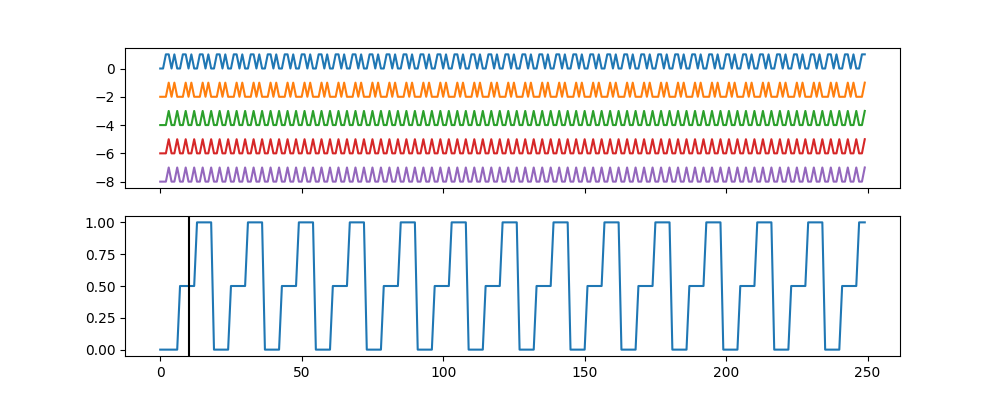

In [15]:
low_lim, high_lim = 0, 250
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 4)) # plt.sca(axes)
ax[0].plot(gestures_protocol[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']][low_lim:high_lim].values - np.arange(5) * 2)
ax[1].plot(gestures_protocol[['Pronation']][low_lim:high_lim].values)
# Для примера сравним сигналы в рйоне 6 периода
plt.axvline(10, color='k', label='Train-Test split')
plt.show()

In [16]:
# add OPEN to protocol
mask_open = (gestures_protocol[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [17]:
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [18]:
# Смотрим все признаки вместе (для информации) 
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)
gestures_train_ext.head()

,0,1,2,3,4,5,6,7,8,9,...,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
0,10,8,29,2846,2929,2873,2598,24,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,8,28,2846,2931,2873,2597,24,8,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16,8,29,2847,2930,2875,2598,24,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,8,29,2847,2930,2875,2598,25,8,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,8,29,2845,2927,2870,2594,24,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
gestures_train_ext.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts', 'Thumb',
       'Index', 'Middle', 'Ring', 'Pinky', 'Thumb_stretch', 'Index_stretch',
       'Middle_stretch', 'Ring_stretch', 'Pinky_stretch', 'Pronation'],
      dtype='object')

In [20]:
gestures_test.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [21]:
gestures_train['ts'].head()

0    1174956
1    1174989
2    1175022
3    1175055
4    1175088
Name: ts, dtype: int64

In [22]:
Pronat = pd.get_dummies(gestures_protocol['Pronation'], prefix='Pronation')
gestures_protocol = pd.concat([gestures_protocol, Pronat], axis=1)
gestures_protocol.drop(['Pronation'], axis=1, inplace=True)

# Features list
PRON = ['Pronation_0.0', 'Pronation_0.5', 'Pronation_1.0']

gestures_protocol.head(2)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation_0.0,Pronation_0.5,Pronation_1.0
epoch,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [23]:
gestures_protocol.shape

(307, 13)

In [24]:
gestures_train.shape

(28976, 65)

In [25]:
gestures_train[['SYNC']]

,SYNC
0,0
1,0
2,0
3,0
4,0
...,...
28971,0
28972,0
28973,0
28974,0


## Composition of X_train

In [26]:
#gestures_train[OMG_CH + GYR_CH + ACC_CH ]

In [27]:
X_train_1, X_test_1 = gestures_train[OMG_CH].values, gestures_test[OMG_CH].values #56
# Предобработка скользящим окном
#X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

display('X_train', pd.DataFrame(X_train_1, columns=OMG_CH).head(2))

y_train_1, y_test_1 = gestures_train[GLOVE_CH].values, gestures_test[GLOVE_CH].values

# Предобработка скользящим окном
#y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
display('y_train', pd.DataFrame(y_train_1, columns=GLOVE_CH).head(2) )#'y_test', y_test.head(2)

'X_train'

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,10,8,29,2846,2929,2873,2598,24,8,6,...,33,31,11,12,8,5,8,15,36,33
1,10,8,28,2846,2931,2873,2597,24,8,13,...,32,28,10,11,8,5,8,13,32,25


'y_train'

,ENC0,ENC1,ENC2,ENC3,ENC4
0,37,50,54,44,5
1,37,50,54,44,5


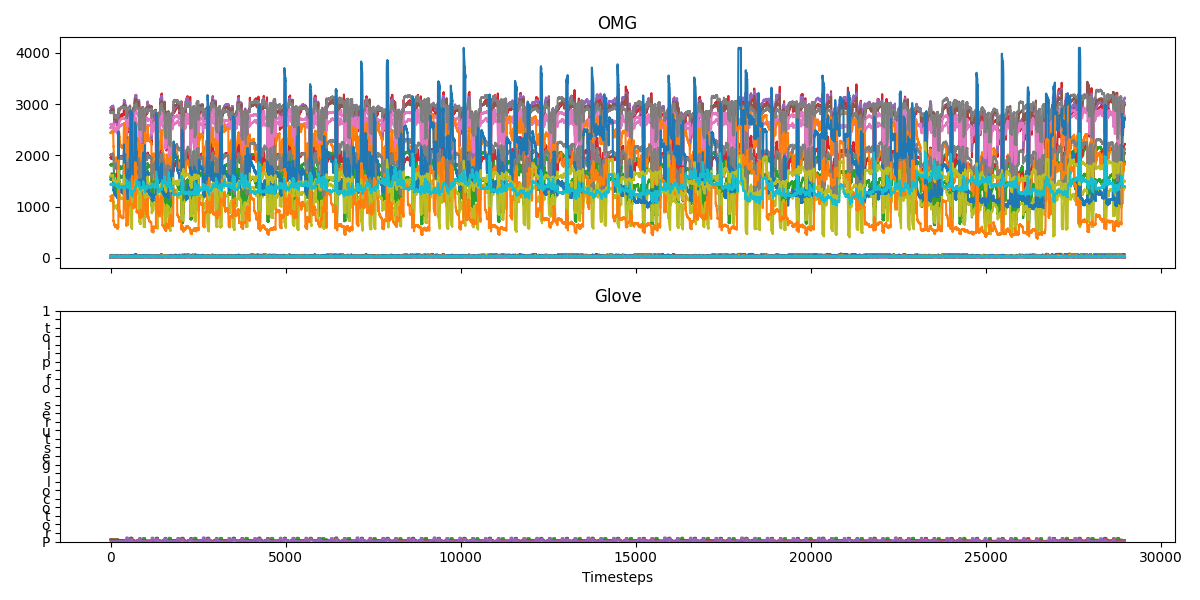

In [28]:
get_signals_plot(X_train_1, y_train_1, 'Protocol gestures of pilot 1')

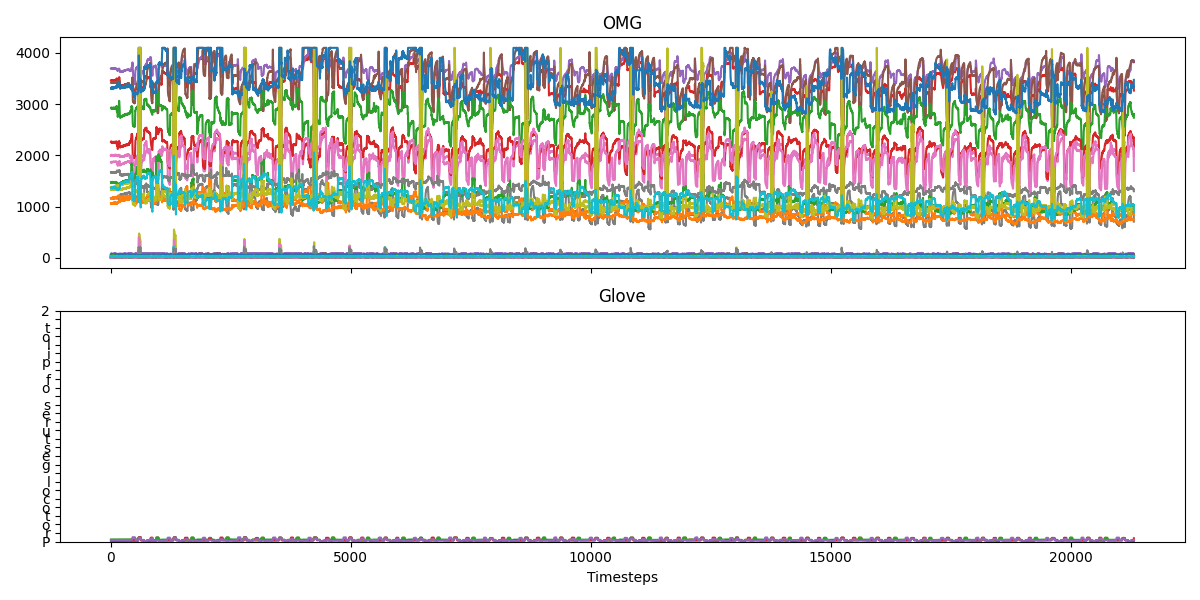

In [29]:
X_train_2, X_test_2 = mounts['gestures_train_2'][OMG_CH].values, mounts['gestures_test_2'][OMG_CH].values #56

y_train_2, y_test_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values
get_signals_plot(X_train_2, y_train_2, 'Protocol gestures of pilot 2')

In [30]:
#X_free, y_free = free_movements.iloc[:,0:50], free_movements[GLOVE_CH]

#display(X_free.head(2),'X_free', X_free.shape, y_free.head(2),y_free.shape)

In [31]:
#get_signals_plot(X_free, y_free, 'Free signals')

# Preprocessing

In [32]:
# Combine 2 pilots data
 
X_train_raw, X_test_raw= np.concatenate((X_train_1, X_train_2), axis=0), np.concatenate((X_test_1, X_test_2), axis=0)
y_train, y_test = np.concatenate((y_train_1, y_train_2), axis=0), np.concatenate((y_test_1, y_test_2), axis=0)
X_train_raw.shape

(50296, 50)

In [33]:
# Smoothing of sensor signals
X_train = np.transpose([savgol_filter(X_train_raw[:,i], window_length=25, polyorder=5) for i in range(X_train_raw.shape[1])]) 
X_test = np.transpose([savgol_filter(X_test_raw[:,i], window_length=25, polyorder=5) for i in range(X_test_raw.shape[1])])

# X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
# X_train.head(1)

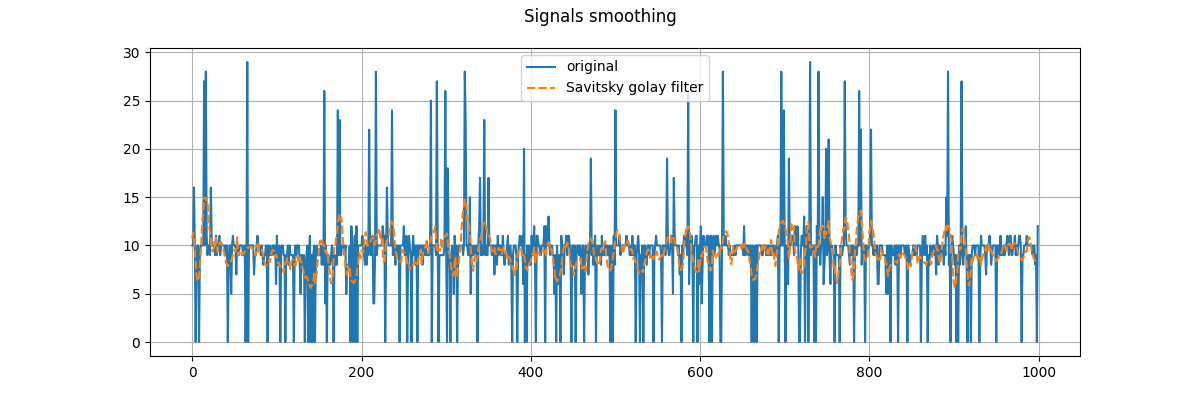

In [34]:
# Smoothing of sensor 0 signal

temp = pd.DataFrame({
    'original':X_train_raw[:1000,0], 
    'Savitsky golay filter':X_train[:1000,0], 
    #'digital filter':X_train.iloc[:,0]
})

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(temp)
plt.suptitle('Signals smoothing')
plt.grid()

In [35]:
# Add differential values
# X_train, X_test = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5)

In [36]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test) 
#display(pd.DataFrame(X_train, columns=COLS).head(1))

In [37]:
# a = np.array([[0],[1],[2],[3],[4],[6],[8],[10],[12]])
# b = np.vstack([(a-np.roll(a, 5, axis=0))[5:]])
# print(a)
# print('')
# print(b)
# add_diff(a, shift_=5)

# Modeling